In [ ]:
# Importing the libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from opensky_api import OpenSkyApi
import folium
from folium.plugins import HeatMap
import ipywidgets as widgets
from IPython.display import display


In [24]:
# Importing the dataset
vluchten_df = pd.read_csv('40_Vluchten.csv')
twee_uur_df = pd.read_csv('Vluchten_Schiphol_2_uur.csv')
vijftien_uur_df = pd.read_csv('Vluchten_Schiphol_15_uur_lang.csv')

# Adapting the dataset
vluchten_df['time'] = pd.to_datetime(vluchten_df['Time'], errors='coerce')
twee_uur_df['time'] = pd.to_datetime(
    twee_uur_df['Time'] + ', 2025-03-24',  # Append the correct date
    errors='coerce'
)
vijftien_uur_df['time'] = pd.to_datetime(
    vijftien_uur_df['Time'] + ', 2025-03-24',  # Append the correct date
    errors='coerce'
)

vijftien_uur_df.head()

/var/folders/8p/lzt_10x12c52fwzk6d2zn91m0000gn/T/ipykernel_30347/685944930.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vluchten_df['time'] = pd.to_datetime(vluchten_df['Time'], errors='coerce')


,Time,Latitude,Longitude,Course,Speed_kts,Speed_mph,Altitude_feet,ClimbRate,ReportingFacility,FlightType,FlightNumber,ScrapeTime,time
0,Mon 07:13:52 AM,51.5050,0.0604,→ 95°,136.0,157.0,NaN,NaN,FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:13:52
1,Mon 07:14:08 AM,51.5043,0.0751,→ 92°,125.0,144.0,950,"3,047",FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:08
2,Mon 07:14:24 AM,51.5041,0.0909,→ 92°,131.0,151.0,"1,575","1,641",FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:24
3,Mon 07:14:40 AM,51.5055,0.1075,→ 71°,151.0,174.0,"1,825","1,078",FlightAware ADS-B (SEN / EGMC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:40
4,Mon 07:14:56 AM,51.5104,0.1241,↗ 53°,169.0,194.0,"2,150","1,313",FlightAware ADS-B (EGML),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:56


# Getting the data from API's

In [ ]:
# Importing the dataset of Sensornet
start_date = int(pd.to_datetime('2025-03-24').timestamp())
end_date = int(pd.to_datetime('2025-03-25').timestamp())

response =requests.get(f'https://sensornet.nl/dataserver3/event/collection/nina_events/stream?conditions%5B0%5D%5B%5D=time&conditions%5B0%5D%5B%5D=%3E%3D&conditions%5B0%5D%5B%5D={start_date}&conditions%5B1%5D%5B%5D=time&conditions%5B1%5D%5B%5D=%3C&conditions%5B1%5D%5B%5D={end_date}&conditions%5B2%5D%5B%5D=label&conditions%5B2%5D%5B%5D=in&conditions%5B2%5D%5B2%5D%5B%5D=21&conditions%5B2%5D%5B2%5D%5B%5D=32&conditions%5B2%5D%5B2%5D%5B%5D=33&conditions%5B2%5D%5B2%5D%5B%5D=34&args%5B%5D=aalsmeer&args%5B%5D=schiphol&fields%5B%5D=time&fields%5B%5D=location_short&fields%5B%5D=location_long&fields%5B%5D=duration&fields%5B%5D=SEL&fields%5B%5D=SELd&fields%5B%5D=SELe&fields%5B%5D=SELn&fields%5B%5D=SELden&fields%5B%5D=SEL_dB&fields%5B%5D=lasmax_dB&fields%5B%5D=callsign&fields%5B%5D=type&fields%5B%5D=altitude&fields%5B%5D=distance&fields%5B%5D=winddirection&fields%5B%5D=windspeed&fields%5B%5D=label&fields%5B%5D=hex_s&fields%5B%5D=registration&fields%5B%5D=icao_type&fields%5B%5D=serial&fields%5B%5D=operator&fields%5B%5D=tags')

colnames = pd.DataFrame(response.json()['metadata'])
sensornet = pd.DataFrame(response.json()['rows'])
sensornet.columns = colnames.headers

sensornet['time'] = pd.to_datetime(sensornet['time'], unit = 's')

print(sensornet['time'].min(),sensornet['time'].max())

pd.options.display.max_columns = None

sensornet['time'] = sensornet['time'].dt.round('1min')
sensornet.head()

2025-03-24 00:39:52 2025-03-24 23:30:27


headers,id,location_short,location_long,time,SELd,SELe,SELn,SELden,SEL,SEL_dB,lasmax_dB,distance,altitude,label,windspeed,winddirection,callsign,type,tags,duration,hex_s,registration,icao_type,serial,operator
0,132545731,Aa,Aalsmeerderweg,2025-03-24 04:21:00,0,0,14369200,143692000,14369200,71.574311,55.4,2494.400,209.968,21,3.0,311.0,KLM590,None,Zwanenburgbaan36C_L,139,485B45,None,None,None,None
1,132545741,Aa,Aalsmeerderweg,2025-03-24 04:37:00,0,0,9986500,99865000,9986500,69.994131,58.7,2496.400,207.807,21,3.0,311.0,KLM272,Boeing 787-9,Zwanenburgbaan36C_L,36,485344,PH-BHL,B789,38775,KLM Royal Dutch Airlines
2,132545791,Aa,Aalsmeerderweg,2025-03-24 06:41:00,100557000,0,0,100557000,100557000,80.024142,69.8,332.837,130.063,21,3.0,333.0,KLM92B,None,Aalsmeerbaan36R_L,52,486493,None,None,None,None
3,132545801,Aa,Aalsmeerderweg,2025-03-24 06:44:00,528377000,0,0,528377000,528377000,87.229442,77.7,333.348,127.751,21,3.0,333.0,UAE145,Boeing 777 31HER,Aalsmeerbaan36R_L,50,8963DD,A6-EPN,B77W,42333,Emirates
4,132545811,Aa,Aalsmeerderweg,2025-03-24 06:52:00,163569000,0,0,163569000,163569000,82.136997,74.3,331.436,125.018,21,4.0,329.0,KLM79Y,Embraer ERJ 170-200 STD,Aalsmeerbaan36R_L,40,485779,PH-EXS,E75L,17000702,Klm Cityhopper


In [6]:
from datetime import datetime
import pandas as pd
from opensky_api import OpenSkyApi

# Initialize the OpenSkyApi instance
api = OpenSkyApi()

# Define the specific 2-hour time interval on March 24, 2025
begin = int(datetime(2025, 3, 24, 14, 0, 0).timestamp())  # Start of the interval (e.g., 14:00)
end = int(datetime(2025, 3, 24, 16, 0, 0).timestamp())    # End of the interval (e.g., 16:00)

flights = api.get_flights_from_interval(begin, end)

# Create a pandas DataFrame
opensky = pd.DataFrame(all_data, columns=columns)

# Convert 'time_position' and 'last_contact' to human-readable datetime format
opensky['time_position_readable'] = pd.to_datetime(opensky['time_position'], unit='s', errors='coerce')
opensky['last_contact_readable'] = pd.to_datetime(opensky['last_contact'], unit='s', errors='coerce')

# Display the DataFrame
pd.options.display.max_columns = None
print("Flight data for the specified time range:")
display(opensky.head(20))

ReadTimeout: HTTPSConnectionPool(host='opensky-network.org', port=443): Read timed out. (read timeout=15.0)

# Experimenteren Hoofdvraag: Hoeveel geluid maakt een vlucht in een gebied rondom Schiphol

In [ ]:
sensornet.head()

headers,id,location_short,location_long,time,SELd,SELe,SELn,SELden,SEL,SEL_dB,lasmax_dB,distance,altitude,label,windspeed,winddirection,callsign,type,tags,duration,hex_s,registration,icao_type,serial,operator
0,132545731,Aa,Aalsmeerderweg,2025-03-24 04:21:00,0,0,14369200,143692000,14369200,71.574311,55.4,2494.400,209.968,21,3.0,311.0,KLM590,None,Zwanenburgbaan36C_L,139,485B45,None,None,None,None
1,132545741,Aa,Aalsmeerderweg,2025-03-24 04:37:00,0,0,9986500,99865000,9986500,69.994131,58.7,2496.400,207.807,21,3.0,311.0,KLM272,Boeing 787-9,Zwanenburgbaan36C_L,36,485344,PH-BHL,B789,38775,KLM Royal Dutch Airlines
2,132545791,Aa,Aalsmeerderweg,2025-03-24 06:41:00,100557000,0,0,100557000,100557000,80.024142,69.8,332.837,130.063,21,3.0,333.0,KLM92B,None,Aalsmeerbaan36R_L,52,486493,None,None,None,None
3,132545801,Aa,Aalsmeerderweg,2025-03-24 06:44:00,528377000,0,0,528377000,528377000,87.229442,77.7,333.348,127.751,21,3.0,333.0,UAE145,Boeing 777 31HER,Aalsmeerbaan36R_L,50,8963DD,A6-EPN,B77W,42333,Emirates
4,132545811,Aa,Aalsmeerderweg,2025-03-24 06:52:00,163569000,0,0,163569000,163569000,82.136997,74.3,331.436,125.018,21,4.0,329.0,KLM79Y,Embraer ERJ 170-200 STD,Aalsmeerbaan36R_L,40,485779,PH-EXS,E75L,17000702,Klm Cityhopper


In [37]:
import folium
from folium.plugins import AntPath

# Filter for KLM888, KLM1126, and KLM1902 flights
klm888_df = vijftien_uur_df[vijftien_uur_df['FlightNumber'] == 'KLM888']
klm1126_df = vijftien_uur_df[vijftien_uur_df['FlightNumber'] == 'KLM1126']
klm1902_df = vijftien_uur_df[vijftien_uur_df['FlightNumber'] == 'KLM1902']

# Ensure the data is sorted by time if available
if 'time' in klm888_df.columns:
    klm888_df = klm888_df.sort_values(by='time')

if 'time' in klm1126_df.columns:
    klm1126_df = klm1126_df.sort_values(by='time')

if 'time' in klm1902_df.columns:
    klm1902_df = klm1902_df.sort_values(by='time')

# Extract coordinates (Latitude, Longitude) as a list of tuples
route_coords_klm888 = list(zip(klm888_df['Latitude'], klm888_df['Longitude']))
route_coords_klm1126 = list(zip(klm1126_df['Latitude'], klm1126_df['Longitude']))
route_coords_klm1902 = list(zip(klm1902_df['Latitude'], klm1902_df['Longitude']))

# Define the bounding box for the Netherlands (approximately)
min_lat, max_lat = 50.75, 53.75  # Approximate latitude range for Netherlands
min_lon, max_lon = 3.25, 7.5     # Approximate longitude range for Netherlands

# Filter the coordinates to only include those within the Netherlands' bounding box
filtered_coords_klm888 = [coord for coord in route_coords_klm888 if min_lat <= coord[0] <= max_lat and min_lon <= coord[1] <= max_lon]
filtered_coords_klm1126 = [coord for coord in route_coords_klm1126 if min_lat <= coord[0] <= max_lat and min_lon <= coord[1] <= max_lon]
filtered_coords_klm1902 = [coord for coord in route_coords_klm1902 if min_lat <= coord[0] <= max_lat and min_lon <= coord[1] <= max_lon]

# Create the map centered on the Netherlands
flight_map = folium.Map(location=[52.4, 5], zoom_start=9)

# Add the KLM888 flight path using AntPath (creates a moving dashed effect to indicate direction)
AntPath(
    filtered_coords_klm888,
    color="blue",
    weight=3,
    opacity=0.8,
    delay=1000  # Adjust delay for animation speed
).add_to(flight_map)

# Add the KLM1126 flight path using AntPath (creates a moving dashed effect to indicate direction)
AntPath(
    filtered_coords_klm1126,
    color="red",
    weight=3,
    opacity=0.8,
    delay=1000  # Adjust delay for animation speed
).add_to(flight_map)

# Add the KLM1902 flight path using AntPath (creates a moving dashed effect to indicate direction)
AntPath(
    filtered_coords_klm1902,
    color="green",
    weight=3,
    opacity=0.8,
    delay=1000  # Adjust delay for animation speed
).add_to(flight_map)

# Create a custom legend for the flight routes with lines instead of dots
legend_html = '''
     <div style="position: fixed; 
                 bottom: 30px; left: 30px; width: 250px; height: 150px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 padding: 10px;">
         <p style="text-align: center; font-size: 16px; margin: 5px; font-weight: bold;">Flight Routes</p>
         <p><span style="display:inline-block; width: 30px; height: 5px; background-color:blue; margin-left:10px;"></span> KLM888</p>
         <p><span style="display:inline-block; width: 30px; height: 5px; background-color:red; margin-left:10px;"></span> KLM1126</p>
         <p><span style="display:inline-block; width: 30px; height: 5px; background-color:green; margin-left:10px;"></span> KLM1902</p>
     </div>
'''

# Add the legend to the map
flight_map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
display(flight_map)



In [8]:
common_callsigns = set(sensornet['callsign']).intersection(set(vijftien_uur_df['FlightNumber']))
print(common_callsigns)

klm1126_sensornet = sensornet['callsign'].value_counts().get('KLM1902', 0)
klm1126_vijftien = vijftien_uur_df['FlightNumber'].value_counts().get('KLM1902', 0)

print(f"KLM1126 appears {klm1126_sensornet} times in sensornet")
print(f"KLM1126 appears {klm1126_vijftien} times in vijftien_uur_df")


{'DAL132', 'KLM602', 'NJE205D', 'DAL162', 'CND168', 'TRA5426', 'BTI6D9', 'CKK205', 'DAL72', 'TRA6904', 'TRA5752', 'KLJ2985', 'MSR757', 'KLM1780', 'AFR1840', 'ETD913', 'KLM1344', 'VJT842', 'PGT1259', 'AIC155', 'KLM888', 'KLM1928', 'KLM760', 'KLM9888', 'UAL946', 'UAL909', 'SAS1557', 'DLH996', 'CXA811', 'CES771', 'KLM428', 'KLM1750', 'DAL134', 'NJE8PQ', 'SAS549', 'JVW474', 'YZR7413', 'KLM755', 'KLM1782', 'KLM1048', 'KLM1016', 'UAL20', 'UAE9912', 'CND932P', 'KLM1920', 'KLM1368', 'CND5997', 'KLM872', 'KLM1512', 'DAL242', 'KLM934', 'KLM1641', 'KLM1316', 'KLM1856', 'KLM1938', 'KLM1622', 'KLM1440', 'DAL74', 'SIA7343', 'KLM1602', 'CND124', 'NJE622F', 'KLM916', 'ELY339', 'TAP668', 'KLM1314', 'CSN307', 'KLM642', 'TFL9524', 'KLM1754', 'KLM1298', 'KLM896', 'KLM1628', 'KLM878', 'TRA6114', 'KLM702', 'KLM1452', 'SVA215', 'KLM1206', 'KLM1708', 'KLM1508', 'KLM862', 'TFL3802', 'KLM1342', 'KLM1776', 'KLM946', 'KLM1936', 'SWR736', 'KLM590', 'KLM1246', 'KLM1318', 'KLM932', 'KLM844', 'AZG201', 'KLM1830', 'GA

In [47]:
# Filter sensornet dataframe for rows where 'callsign' equals 'KLM1902'
KLM1902_sensor = sensornet[sensornet['callsign'] == 'KLM1902']

# Adjust the time in KLM1902_sensor by subtracting 4 hours (since it is 4 hours ahead)
KLM1902_sensor['time'] = KLM1902_sensor['time'] - pd.Timedelta(hours=4)

KLM1902_sensor.head()

/var/folders/8p/lzt_10x12c52fwzk6d2zn91m0000gn/T/ipykernel_30347/1499940885.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KLM1902_sensor['time'] = KLM1902_sensor['time'] - pd.Timedelta(hours=4)


headers,id,location_short,location_long,time,SELd,SELe,SELn,SELden,SEL,SEL_dB,lasmax_dB,distance,altitude,label,windspeed,winddirection,callsign,type,tags,duration,hex_s,registration,icao_type,serial,operator
161,132547411,Aa,Aalsmeerderweg,2025-03-24 09:29:00,192835000,0,0,192835000,192835000,82.851853,72.8,327.113,112.790,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,50,48415F,PH-BXF,B738,29596,
561,132551521,Da,Darwinstraat,2025-03-24 09:28:00,76841400,0,0,76841400,76841400,78.855953,65.4,943.326,340.599,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,67,48415F,PH-BXF,B738,29596,
1388,132563791,Co,Copierstraat,2025-03-24 09:28:00,2402810,0,0,2402810,2402810,63.807189,53.2,2251.770,377.711,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,32,48415F,PH-BXF,B738,29596,
1872,132568741,Ku,Kudelstaartseweg,2025-03-24 09:28:00,14304500,0,0,14304500,14304500,71.554727,59.3,1697.050,339.809,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,66,48415F,PH-BXF,B738,29596,
2302,132543701,Bl,Blaauwstraat,2025-03-24 09:29:00,999869000,0,0,999869000,999869000,89.999431,83.2,156.620,151.454,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,47,48415F,PH-BXF,B738,29596,


In [49]:
import pandas as pd

# Filter the KLM1902_vluchten dataframe for the flight number 'KLM1902'
KLM1902_vluchten = vijftien_uur_df[vijftien_uur_df['FlightNumber'] == 'KLM1902']

# Ensure the 'time' column is in datetime format (if it's not already)
KLM1902_vluchten['time'] = pd.to_datetime(KLM1902_vluchten['time'])

# Round the 'time' values to the nearest minute
KLM1902_vluchten['time'] = KLM1902_vluchten['time'].dt.floor('T')

# Display the dataframe to see the rounded time values
KLM1902_vluchten.head(200)

/var/folders/8p/lzt_10x12c52fwzk6d2zn91m0000gn/T/ipykernel_30347/2915438450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KLM1902_vluchten['time'] = pd.to_datetime(KLM1902_vluchten['time'])
/var/folders/8p/lzt_10x12c52fwzk6d2zn91m0000gn/T/ipykernel_30347/2915438450.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  KLM1902_vluchten['time'] = KLM1902_vluchten['time'].dt.floor('T')
/var/folders/8p/lzt_10x12c52fwzk6d2zn91m0000gn/T/ipykernel_30347/2915438450.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

,Time,Latitude,Longitude,Course,Speed_kts,Speed_mph,Altitude_feet,ClimbRate,ReportingFacility,FlightType,FlightNumber,ScrapeTime,time
26261,Mon 08:03:43 AM,48.1218,16.5775,↑ 346°,177.0,204.0,"1,050",NaN,FlightAware ADS-B (VIE / LOWW),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 08:03:00
26262,Mon 08:03:59 AM,48.1354,16.5721,↑ 347°,182.0,209.0,"1,675","2,016",FlightAware ADS-B (VIE / LOWW),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 08:03:00
26263,Mon 08:04:15 AM,48.1497,16.5749,↗ 22°,203.0,234.0,"2,125","2,297",FlightAware ADS-B (VIE / LOWW),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 08:04:00
26264,Mon 08:04:31 AM,48.1612,16.5877,↗ 40°,211.0,243.0,"2,900","2,719",FlightAware ADS-B (VIE / LOWW),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 08:04:00
26265,Mon 08:04:47 AM,48.1738,16.6034,↗ 39°,225.0,259.0,"3,575","3,000",FlightAware ADS-B (LOAF),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 08:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,Mon 09:28:18 AM,52.2466,4.7733,↑ 3°,141.0,162.0,800,-703,FlightAware ADS-B (EHDB),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 09:28:00
26447,Mon 09:28:34 AM,52.2566,4.7743,↑ 4°,137.0,158.0,650,-797,FlightAware ADS-B (EHDB),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 09:28:00
26448,Mon 09:28:50 AM,52.2673,4.7752,↑ 3°,138.0,159.0,375,-844,FlightAware ADS-B (AMS / EHAM),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 09:28:00
26449,Mon 09:29:06 AM,52.2771,4.7762,↑ 4°,138.0,159.0,200,-630,FlightAware ADS-B (AMS / EHAM),Arrivals,KLM1902,2025-03-24 14:50:59,2025-03-24 09:29:00


In [46]:
import pandas as pd

# Adjust the time in KLM1902_sensor by subtracting 4 hours (since it is 4 hours ahead)
KLM1902_sensor['time'] = KLM1902_sensor['time'] - pd.Timedelta(hours=4)

# Rename 'FlightNumber' to 'callsign' in KLM1902_vluchten for consistency
KLM1902_vluchten = KLM1902_vluchten.rename(columns={'FlightNumber': 'callsign'})

# Sort both dataframes by 'time' (required for merge_asof)
KLM1902_sensor = KLM1902_sensor.sort_values(by='time')
KLM1902_vluchten = KLM1902_vluchten.sort_values(by='time')

# Merge the dataframes using 'merge_asof' to find the closest time within 5 minutes
merged_df = pd.merge_asof(
    KLM1902_sensor, 
    KLM1902_vluchten, 
    left_on='time', 
    right_on='time', 
    by='callsign',  # Merge based on 'callsign' for KLM1902
    direction='nearest',  # Take the closest time
    tolerance=pd.Timedelta('1 minute')  # Set tolerance to 5 minutes for time difference
)

# Display the merged dataframe
display(merged_df)


,id,location_short,location_long,time,SELd,SELe,SELn,SELden,SEL,SEL_dB,lasmax_dB,distance,altitude,label,windspeed,winddirection,callsign,type,tags,duration,hex_s,registration,icao_type,serial,operator,Time,Latitude,Longitude,Course,Speed_kts,Speed_mph,Altitude_feet,ClimbRate,ReportingFacility,FlightType,ScrapeTime
0,132551521,Da,Darwinstraat,2025-03-23 17:28:00,76841400,0,0,76841400,76841400,78.855953,65.4,943.326,340.599,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,67,48415F,PH-BXF,B738,29596,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,132563791,Co,Copierstraat,2025-03-23 17:28:00,2402810,0,0,2402810,2402810,63.807189,53.2,2251.770,377.711,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,32,48415F,PH-BXF,B738,29596,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,132568741,Ku,Kudelstaartseweg,2025-03-23 17:28:00,14304500,0,0,14304500,14304500,71.554727,59.3,1697.050,339.809,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,66,48415F,PH-BXF,B738,29596,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132547411,Aa,Aalsmeerderweg,2025-03-23 17:29:00,192835000,0,0,192835000,192835000,82.851853,72.8,327.113,112.790,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,50,48415F,PH-BXF,B738,29596,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,132543701,Bl,Blaauwstraat,2025-03-23 17:29:00,999869000,0,0,999869000,999869000,89.999431,83.2,156.620,151.454,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,47,48415F,PH-BXF,B738,29596,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,132559051,Ho,Hornweg,2025-03-23 17:29:00,31764800,0,0,31764800,31764800,75.019467,63.6,841.967,125.162,21,5.0,316.0,KLM1902,Boeing 737-800,Aalsmeerbaan36R_L,40,48415F,PH-BXF,B738,29596,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import folium
from folium.plugins import AntPath

# Filter for KLM888, KLM1126, and KLM1902 flights
klm888_df = vijftien_uur_df[vijftien_uur_df['FlightNumber'] == 'KLM888']
klm1126_df = vijftien_uur_df[vijftien_uur_df['FlightNumber'] == 'KLM1126']
klm1902_df = vijftien_uur_df[vijftien_uur_df['FlightNumber'] == 'KLM1902']

# Ensure the data is sorted by time if available
if 'time' in klm888_df.columns:
    klm888_df = klm888_df.sort_values(by='time')

if 'time' in klm1126_df.columns:
    klm1126_df = klm1126_df.sort_values(by='time')

if 'time' in klm1902_df.columns:
    klm1902_df = klm1902_df.sort_values(by='time')

# Extract coordinates (Latitude, Longitude) as a list of tuples
route_coords_klm888 = list(zip(klm888_df['Latitude'], klm888_df['Longitude']))
route_coords_klm1126 = list(zip(klm1126_df['Latitude'], klm1126_df['Longitude']))
route_coords_klm1902 = list(zip(klm1902_df['Latitude'], klm1902_df['Longitude']))

# Define the bounding box for the Netherlands (approximately)
min_lat, max_lat = 50.75, 53.75  # Approximate latitude range for Netherlands
min_lon, max_lon = 3.25, 7.5     # Approximate longitude range for Netherlands

# Filter the coordinates to only include those within the Netherlands' bounding box
filtered_coords_klm888 = [coord for coord in route_coords_klm888 if min_lat <= coord[0] <= max_lat and min_lon <= coord[1] <= max_lon]
filtered_coords_klm1126 = [coord for coord in route_coords_klm1126 if min_lat <= coord[0] <= max_lat and min_lon <= coord[1] <= max_lon]
filtered_coords_klm1902 = [coord for coord in route_coords_klm1902 if min_lat <= coord[0] <= max_lat and min_lon <= coord[1] <= max_lon]

# Sensor coordinates (location_short)
sensor_coordinates = {
    "Aa": (52.2709, 4.7699), "Bi": (52.2647, 4.7746), "Co": (52.2290, 4.7393),
    "Da": (52.2347, 4.7588), "Ho": (52.2683, 4.7871), "Ku": (52.2365, 4.7490),
    "Ui": (52.2632, 4.7365)
}

# Create the map centered on the Netherlands
flight_map = folium.Map(location=[52.4, 5], zoom_start=9)

# Add the KLM888 flight path using AntPath (creates a moving dashed effect to indicate direction)
AntPath(
    filtered_coords_klm888,
    color="blue",
    weight=3,
    opacity=0.8,
    delay=1000  # Adjust delay for animation speed
).add_to(flight_map)

# Add the KLM1126 flight path using AntPath (creates a moving dashed effect to indicate direction)
AntPath(
    filtered_coords_klm1126,
    color="red",
    weight=3,
    opacity=0.8,
    delay=1000  # Adjust delay for animation speed
).add_to(flight_map)

# Add the KLM1902 flight path using AntPath (creates a moving dashed effect to indicate direction)
AntPath(
    filtered_coords_klm1902,
    color="green",
    weight=3,
    opacity=0.8,
    delay=1000  # Adjust delay for animation speed
).add_to(flight_map)

# Add sensor locations as dots (Markers) with SEL_dB data in the popup
for sensor, coord in sensor_coordinates.items():
    # Get the SEL_dB data for this sensor from sensornet (filter by location_short)
    sensor_data = sensornet[sensornet['location_short'] == sensor]  # Assuming `location_short` is the column for sensor names
    if not sensor_data.empty:
        # If there is sensor data available, use the latest value or first available value for SEL_dB
        sel_db_value = sensor_data['SEL_dB'].iloc[0]  # Or use any logic to select the desired value

        # Create the popup message to display SEL_dB value
        popup_message = f"Sensor: {sensor}<br>Sound Level (SEL_dB): {sel_db_value}"

        # Add a marker for the sensor with the popup (sensor name as icon)
        folium.Marker(
            location=coord,
            popup=popup_message,
            icon=folium.Icon(color='orange', icon_color='black', icon=f'{sensor}', prefix='fa')  # Use the sensor name as icon
        ).add_to(flight_map)
    else:
        # In case no data is available, just add the marker with a generic message
        folium.Marker(
            location=coord,
            popup=f"Sensor: {sensor}<br>No SEL_dB data available",
            icon=folium.Icon(color='orange', icon_color='black', icon=f'{sensor}', prefix='fa')  # Use the sensor name as icon
        ).add_to(flight_map)

# Create a custom legend for the flight routes with lines instead of dots
legend_html = '''
     <div style="position: fixed; 
                 bottom: 30px; left: 30px; width: 250px; height: 150px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 padding: 10px;">
         <p style="text-align: center; font-size: 16px; margin: 5px; font-weight: bold;">Flight Routes</p>
         <p><span style="display:inline-block; width: 30px; height: 5px; background-color:blue; margin-left:10px;"></span> KLM888</p>
         <p><span style="display:inline-block; width: 30px; height: 5px; background-color:red; margin-left:10px;"></span> KLM1126</p>
         <p><span style="display:inline-block; width: 30px; height: 5px; background-color:green; margin-left:10px;"></span> KLM1902</p>
     </div>
'''

# Add the legend to the map
flight_map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
display(flight_map)


# Note to self KLM888 (or whatever it's called) is also in the sensordata dataframe. Use this to calculate the sound of this one plane

In [ ]:
shared_values = set(sensornet['callsign']).intersection(set(vijftien_uur_df['FlightNumber']))
print(shared_values)

klm888_sensornet_count = sensornet['callsign'].value_counts().get('KLM888', 0)
klm888_vijftien_count = vijftien_uur_df['FlightNumber'].value_counts().get('KLM888', 0)

print(f"KLM888 appears {klm888_sensornet_count} times in sensornet")
print(f"KLM888 appears {klm888_vijftien_count} times in vijftien_uur_df")



{'AFR1440', 'CND5997', 'KLM888', 'KLM1960', 'KLM1318', 'UAE9912', 'DAL72', 'KLM1920', 'KLM1048', 'NJE8PQ', 'KLM1814', 'SAS2551', 'TRA6148', 'KLM744', 'BCS1443', 'ITY112', 'KLM1754', 'KLM1170', 'KLM642', 'DLH996', 'KLM1928', 'KLM1016', 'KLM1936', 'SVA215', 'KLM1944', 'DAL162', 'CPA271', 'KLM1142', 'KLM1654', 'KLM1226', 'KLM1342', 'ZXP04', 'KLM1622', 'KLM1708', 'JVW474', 'UAE149', 'KLM932', 'ETD913', 'KLM1314', 'RYR5298', 'KLM1038', 'KLM878', 'KLM702', 'KLM1602', 'TRA5426', 'PGT1253', 'KLM1776', 'CXA811', 'KLM1206', 'KLM428', 'AIC155', 'ITY110', 'KLM946', 'KLM1248', 'KLM1274', 'CAO3159', 'AZG201', 'UAL946', 'TRA5752', 'KLM760', 'KLM1512', 'UAL70', 'SAS1555', 'KLM872', 'KLM836', 'ELY339', 'KLM1508', 'KLM1368', 'TFL3802', 'DLH992', 'TRA6114', 'KQA116', 'KLM1856', 'AIZ511', 'KLM1902', 'KLM916', 'IBS1793', 'KLM1504', 'NJE205D', 'KLM1412', 'UAL909', 'TRA6866', 'KLM602', 'KLM810', 'KLM1452', 'SAS1557', 'KLM1782', 'TRA6904', 'KLM1798', 'KLM1628', 'TAP668', 'DAL132', 'KLM1010', 'KLM1126', 'KLM19

# Experimenting: Correlatie windrichting (en sterkte) en geluid

In [ ]:
numeric_columns = vijftien_uur_df.select_dtypes(include=['number'])  # Select only numeric columns

# Ensure 'Course' column is a string before applying .str.extract()
if vijftien_uur_df['Course'].dtype == 'object':
	vijftien_uur_df['Course'] = vijftien_uur_df['Course'].str.extract(r'(\d+)').astype(float)

# Group by minute and calculate the mean for numeric columns only
vijftien_uur_df['year'] = vijftien_uur_df['time'].dt.year
vijftien_uur_df['month'] = vijftien_uur_df['time'].dt.month
vijftien_uur_df['day'] = vijftien_uur_df['time'].dt.day
vijftien_uur_df['hour'] = vijftien_uur_df['time'].dt.hour
vijftien_uur_df['minute'] = vijftien_uur_df['time'].dt.minute
vijftien_uur_df.groupby(['year', 'month', 'day', 'hour', 'minute'])[numeric_columns.columns].mean()

vijftien_uur_df['time'] = vijftien_uur_df.assign(
	time=pd.to_datetime(
		vijftien_uur_df[['year', 'month', 'day', 'hour', 'minute']]
		.astype(str)
		.agg('-'.join, axis=1),
		format='%Y-%m-%d-%H-%M'
	)
)['time']

vijftien_uur_df.drop(['day', 'hour', 'minute'], axis=1, inplace=True)
vijftien_uur_df

,Time,Latitude,Longitude,Course,Speed_kts,Speed_mph,Altitude_feet,ClimbRate,ReportingFacility,FlightType,FlightNumber,ScrapeTime,time,year,month
0,Mon 07:13:52 AM,51.5050,0.0604,95.0,136.0,157.0,NaN,NaN,FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:13:00,2025,3
1,Mon 07:14:08 AM,51.5043,0.0751,92.0,125.0,144.0,950,"3,047",FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:00,2025,3
2,Mon 07:14:24 AM,51.5041,0.0909,92.0,131.0,151.0,"1,575","1,641",FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:00,2025,3
3,Mon 07:14:40 AM,51.5055,0.1075,71.0,151.0,174.0,"1,825","1,078",FlightAware ADS-B (SEN / EGMC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:00,2025,3
4,Mon 07:14:56 AM,51.5104,0.1241,53.0,169.0,194.0,"2,150","1,313",FlightAware ADS-B (EGML),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:00,2025,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151187,Tue 04:19:26 AM,47.2192,6.5145,193.0,497.0,572.0,"35,000",NaN,FlightAware ADS-B (EDNL),Departures,KLM1511,2025-03-25 09:27:00,2025-03-24 04:19:00,2025,3
151188,Tue 04:19:45 AM,47.1786,6.5012,193.0,498.0,573.0,"35,000",NaN,FlightAware ADS-B (LSPL),Departures,KLM1511,2025-03-25 09:27:00,2025-03-24 04:19:00,2025,3
151189,Tue 04:20:16 AM,47.1093,6.4784,194.0,499.0,574.0,"35,000",NaN,FlightAware ADS-B (BRN / LSZB),Departures,KLM1511,2025-03-25 09:27:00,2025-03-24 04:20:00,2025,3
151190,Tue 04:20:59 AM,47.0127,6.4468,193.0,500.0,575.0,"35,000",NaN,FlightAware ADS-B (GVA / LSGG),Departures,KLM1511,2025-03-25 09:27:00,2025-03-24 04:20:00,2025,3


In [ ]:
numeric_columns = twee_uur_df.select_dtypes(include=['number'])  # Select only numeric columns

# Ensure 'Course' column is a string before applying .str.extract()
if twee_uur_df['Course'].dtype == 'object':
	twee_uur_df['Course'] = twee_uur_df['Course'].str.extract(r'(\d+)').astype(float)

# Group by minute and calculate the mean for numeric columns only
twee_uur_df['year'] = twee_uur_df['time'].dt.year
twee_uur_df['month'] = twee_uur_df['time'].dt.month
twee_uur_df['day'] = twee_uur_df['time'].dt.day
twee_uur_df['hour'] = twee_uur_df['time'].dt.hour
twee_uur_df['minute'] = twee_uur_df['time'].dt.minute
twee_uur_df.groupby(['year', 'month', 'day', 'hour', 'minute'])[numeric_columns.columns].mean()

twee_uur_df['time'] = twee_uur_df.assign(
	time=pd.to_datetime(
		twee_uur_df[['year', 'month', 'day', 'hour', 'minute']]
		.astype(str)
		.agg('-'.join, axis=1),
		format='%Y-%m-%d-%H-%M'
	)
)['time']

twee_uur_df.drop(['day', 'hour', 'minute'], axis=1, inplace=True)
twee_uur_df

,Time,Latitude,Longitude,Course,Speed_kts,Speed_mph,Altitude_feet,ClimbRate,ReportingFacility,FlightType,FlightNumber,ScrapeTime,time,year,month
0,Mon 07:13:52 AM,51.5050,0.0604,95.0,136.0,157.0,NaN,NaN,FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:13:00,2025,3
1,Mon 07:14:08 AM,51.5043,0.0751,92.0,125.0,144.0,950,"3,047",FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:00,2025,3
2,Mon 07:14:24 AM,51.5041,0.0909,92.0,131.0,151.0,"1,575","1,641",FlightAware ADS-B (LCY / EGLC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:00,2025,3
3,Mon 07:14:40 AM,51.5055,0.1075,71.0,151.0,174.0,"1,825","1,078",FlightAware ADS-B (SEN / EGMC),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:00,2025,3
4,Mon 07:14:56 AM,51.5104,0.1241,53.0,169.0,194.0,"2,150","1,313",FlightAware ADS-B (EGML),Arrivals,CFE8489,2025-03-24 12:58:24,2025-03-24 07:14:00,2025,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27065,Mon 09:43:56 AM,50.3192,3.4983,201.0,491.0,565.0,"34,800","1,400",FlightAware ADS-B (RTM / EHRD),Departures,KLM1531,2025-03-24 14:50:59,2025-03-24 09:43:00,2025,3
27066,Mon 09:44:26 AM,50.2555,3.4592,204.0,488.0,562.0,"35,450","1,181",FlightAware ADS-B (LFPV),Departures,KLM1531,2025-03-24 14:50:59,2025-03-24 09:44:00,2025,3
27067,Mon 09:44:43 AM,50.2194,3.4335,205.0,488.0,562.0,"35,725","1,000",FlightAware ADS-B (GLZ / EHGR),Departures,KLM1531,2025-03-24 14:50:59,2025-03-24 09:44:00,2025,3
27068,Mon 09:45:02 AM,50.1823,3.4051,207.0,485.0,558.0,"36,050","1,025",FlightAware ADS-B (DUS / EDDL),Departures,KLM1531,2025-03-24 14:50:59,2025-03-24 09:45:00,2025,3


In [ ]:
# Merge the datasets
merged_df = pd.merge(sensornet, opensky, on='callsign', how='inner')
merged_df.head(20)

,id,location_short,location_long,time,SELd,SELe,SELn,SELden,SEL,SEL_dB,lasmax_dB,distance,altitude,label,windspeed,winddirection,callsign,type,tags,duration,hex_s,registration,icao_type,serial,operator,latitude_x,longitude_x,icao24,origin_country,time_position,last_contact,longitude_y,latitude_y,baro_altitude,on_ground,velocity,true_track,vertical_rate,sensors,geo_altitude,squawk,spi,position_source,time_position_readable


In [ ]:
# Extract numeric values from the 'Course' column and convert to float
merged_df['Course_numeric'] = merged_df['Course'].str.extract(r'(\d+)').astype(float)

# Calculate the angular difference between Course and winddirection
merged_df['wind_angle_diff'] = (merged_df['Course_numeric'] - merged_df['winddirection']) % 360

# Classify the wind direction
def classify_wind_direction(angle):
    if 135 <= angle <= 225:  # Against the wind
        return 'Against the Wind'
    elif 45 <= angle <= 135 or 225 <= angle <= 315:  # Side wind
        return 'Side Wind'
    else:  # Wind in the back
        return 'Wind in the Back'

merged_df['wind_relation'] = merged_df['wind_angle_diff'].apply(classify_wind_direction)

# Display the updated DataFrame
merged_df[['callsign', 'Course', 'winddirection', 'windspeed', 'wind_angle_diff', 'wind_relation', 'Speed_mph', 'SEL_dB']].head(50)

AttributeError: Can only use .str accessor with string values!

KeyError: 'wind_relation'

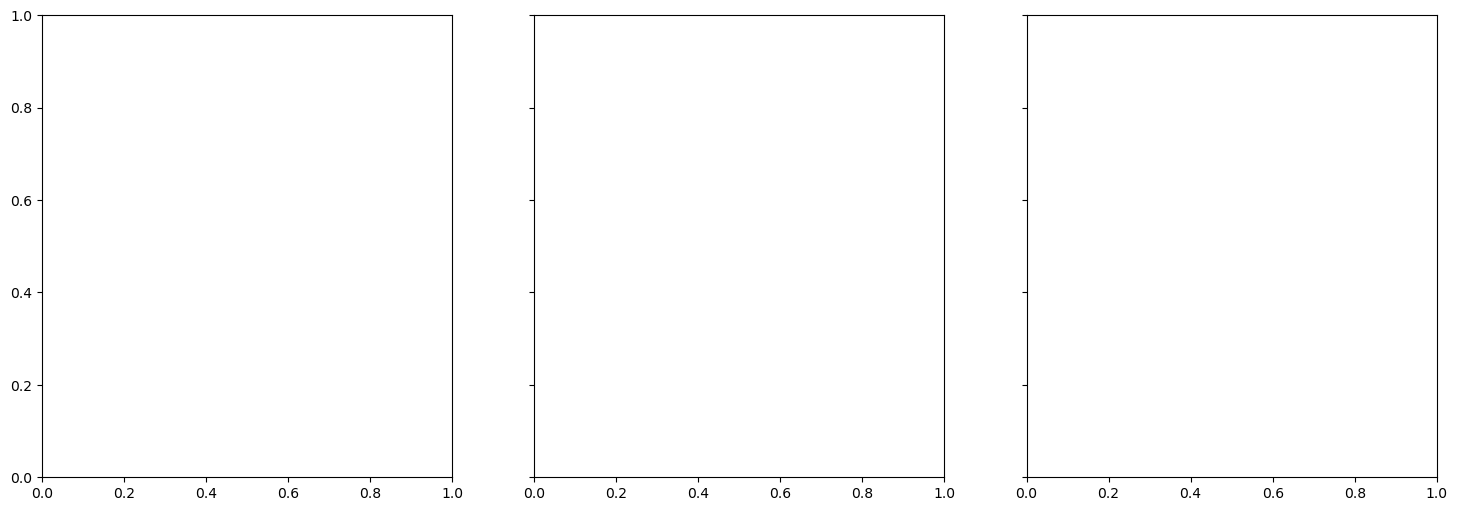

In [ ]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Define the wind_relation categories
wind_categories = ['Against the Wind', 'Side Wind', 'Wind in the Back']

# Create a scatter plot for each wind_relation category
for i, category in enumerate(wind_categories):
    subset = merged_df[merged_df['wind_relation'] == category]
    sns.scatterplot(
        data=subset,
        x='windspeed',
        y='SEL_dB',
        ax=axes[i],
        color='blue'
    )
    axes[i].set_title(f'{category}: Windspeed vs SEL (dB)')
    axes[i].set_xlabel('Windspeed')
    if i == 0:  # Only set the y-axis label for the first subplot
        axes[i].set_ylabel('SEL (dB)')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

/var/folders/8p/lzt_10x12c52fwzk6d2zn91m0000gn/T/ipykernel_24421/3644777222.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=correlation_df, x='wind_relation', y='correlation', palette='viridis')


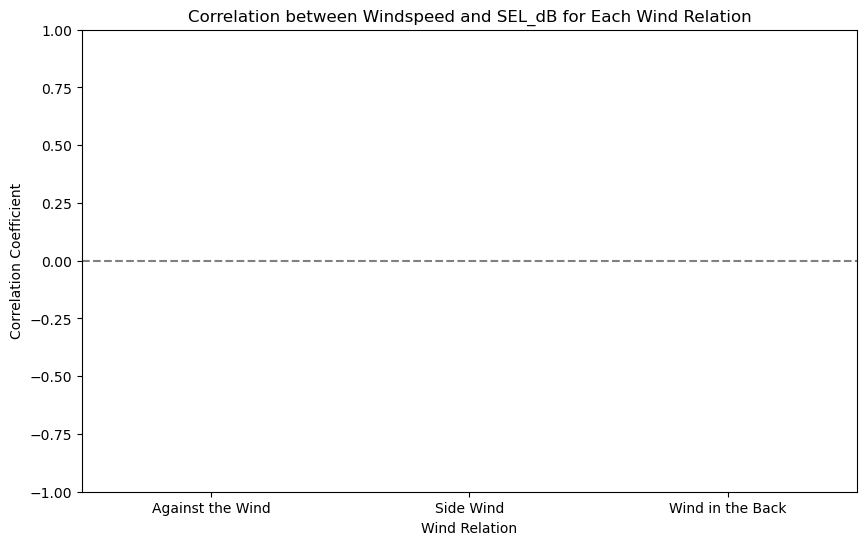

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the wind_relation categories
wind_categories = ['Against the Wind', 'Side Wind', 'Wind in the Back']

# Calculate correlations for each wind_relation category
correlations = {}
for category in wind_categories:
    subset = merged_df[merged_df['wind_relation'] == category]
    if not subset.empty:
        correlations[category] = subset[['windspeed', 'SEL_dB']].corr().iloc[0, 1]  # Correlation between windspeed and SEL_dB
    else:
        correlations[category] = None  # Handle empty subsets

# Convert correlations to a DataFrame for plotting
correlation_df = pd.DataFrame(list(correlations.items()), columns=['wind_relation', 'correlation'])

# Plot the correlations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=correlation_df, x='wind_relation', y='correlation', palette='viridis')
plt.title('Correlation between Windspeed and SEL_dB for Each Wind Relation')
plt.xlabel('Wind Relation')
plt.ylabel('Correlation Coefficient')
plt.ylim(-1, 1)  # Correlation coefficients range from -1 to 1
plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line at 0 for reference
plt.show()